# Periodic Model Violations: Asymmetric Oscillations

In this set of simulations, we will test power spectrum parameterization performance across power spectra which violate some of the assumptions of the model, specifically in the periodic component.

Here, we will explore the case of asymmetric oscillations, in the time domain. 

### Notes on asymmetric oscillations

For these simulations, we will simulate time series, from which we can calculate power spectra, and then fit the model.

We will simulate asymmetric oscillations in the time domain, which create harmonic peaks in the frequency domain. 

Note that non-sinuisoidal or asymmetric oscillations in the time domain do not themselves produce asymmetric peaks in the frequency domain.

### Conclusions

As we will see through these simulations, spectral parameterization can deal pretty well with these simulations, but it does so by fitting peaks to the harmonics. 

This leads to a 'good' model fit, both in terms of appropriately capturing the variance of the data, and in terms of isolating peaks in order to measure the aperiodic component.

However, this property of harmonics exhibiting as peaks does demonstrate that there is not a direct mapping between peaks in the frequency domain, and rhythmic activity (at the peak specific frequency) in the time series

Harmonics mean that power at a particular frequency cannot automatically be assumed to represent activity specific to that frequency. This should always be considered when interpreting detected peaks. Care should be taken to ascertain if and when some of them may be due to harmonics.

In [1]:
%matplotlib inline

In [2]:
from copy import deepcopy
from os.path import join as pjoin

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum_welch
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_times

from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.plts import plot_spectrum
from fooof.data import SimParams
from fooof.sim.params import param_sampler
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '05_mv-peI/'

In [7]:
# Data & Model Setting
GEN_SIMS = True
SAVE_SIMS = True
FIT_MODELS = True
SAVE_MODELS = True

In [8]:
# Run Settings
SAVE_FIG = True
PLT_LOG = True

In [9]:
# Check the conditions to simulate across: rise-decay symmetry values
print('RD Syms: ', RDSYMS)

RD Syms:  [0.5, 0.625, 0.75, 0.875, 1.0]


In [10]:
# Set the number of sims to run (per conditions)
n_sims = N_PSDS

## Asymetric Oscillations in the Time Domain

In [11]:
# Simulation settings
sims = {'sim_oscillation' : {'freq' : 10, 'cycle' : 'asine', 'rdsym' : 0.75},
        'sim_powerlaw' : {'exponent' : -1.5, 'f_range' : (1, None)}}
ex_comp_var = [0.5, 1]

In [12]:
# Simulate the time series
sig = sim_combined(N_SECONDS, FS, sims, ex_comp_var)

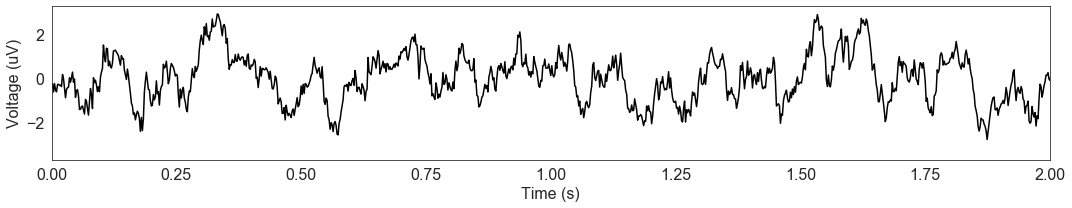

In [13]:
# Check out our simulated time series
plot_time_series(create_times(N_SECONDS, FS), sig, xlim=[0, 2])#, save_fig=SAVE_FIG)

In [14]:
# Compute the power spectrum
freqs, pows = compute_spectrum_welch(sig, FS, nperseg=2*FS, noverlap=FS)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.4283, 1.5229                                          
                                                                                                  
                                       3 peaks were found:                                        
          

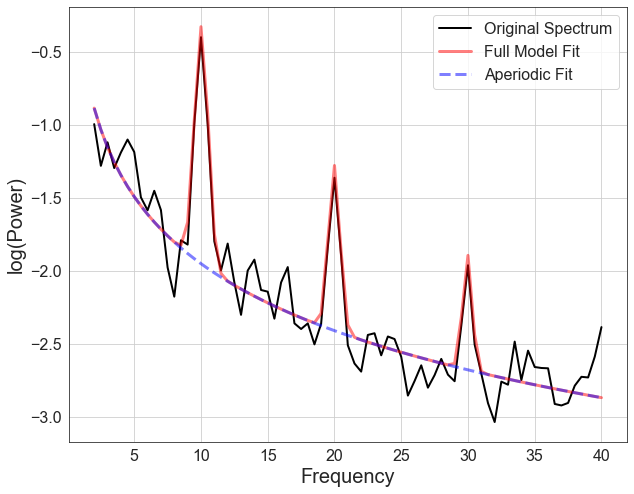

In [15]:
# Fit a FOOOF model
fm = FOOOF(min_peak_height=0.5, verbose=False)
fm.report(freqs, pows, [2, 40])

### Simulate Data

In [16]:
# Get data sizes
n_conds = len(RDSYMS)
n_freqs = len(freqs)

# Set the range to fit with FOOOF
fooof_fit_range = F_RANGE

# Set the time series settings
COMP_VAR = [1, 1]
FILTER_RANGE = (1, None)

# Convert exponent definitions for NeuroDSP format (uses negatives)
EXP_OPTS = [-val for val in EXP_OPTS]

In [17]:
# Generate or load power spectra
data_name = 'mvpe_aosc_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_sims, n_freqs])
    sim_params = [deepcopy([None] * n_sims) for ii in range(n_conds)]
    
    # Initialize generators to sample parameters from
    exp_sampler = param_sampler(EXP_OPTS, EXP_PROBS)
    cf_sampler = param_sampler(CF_OPTS, CF_PROBS)

    # Generate simulated power spectra
    for n_ind, rd_sym in enumerate(RDSYMS):
        
        for s_ind in range(n_sims):
        
            # Get the current values to use for the exponent and peak frequency
            exp_val = next(exp_sampler)
            cf_val = next(cf_sampler)

            # Collect together simulated parameters
            sim_params[n_ind][s_ind] = SimParams([None, exp_val],
                                                 [cf_val, None, None],
                                                 None)

            # Simulation settings for time series
            sims = {'sim_oscillation' : {'freq' : cf_val,
                                         'cycle' : 'asine',
                                         'rdsym' : rd_sym},
                    'sim_powerlaw' : {'exponent' : exp_val,
                                      'f_range' : FILTER_RANGE}}

            # Simulate the time series
            sig = sim_combined(N_SECONDS, FS, sims, COMP_VAR)

            # Compute the power spectrum
            _, psds[n_ind, s_ind, :] = compute_spectrum_welch(\
                sig, FS, nperseg=2*FS, noverlap=FS)
            
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
        
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (5, 1000, 501)


In [18]:
# Extract ground truth values of the simulations
osc_truths, ap_truths = get_ground_truth(sim_params)

# Extract parameters of interest, and force arrays back to float
cf_truths = np.array(osc_truths[:, :, 0], dtype=float)
exp_truths = np.array(ap_truths[:, :, 1], dtype=float) * -1

### Fit Power Spectra with FOOOF

In [19]:
# Initialize FOOOFGroup to fit with
fg = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [20]:
# Fit power spectra
if FIT_MODELS:
    fgs = fit_fooof_3d(fg, freqs, psds, fooof_fit_range)
    
    if SAVE_MODELS:
        save_model_data(data_name, FOLDER, fgs)
            
else:
    # Reload model fit data
    fgs = load_model_data(data_name, FOLDER, n_conds)

### Extract FOOOF fit Data

In [21]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

cf_fits = np.array(peak_fits[:, :, 0], dtype=float)
exp_fits = np.array(ap_fits[:, :, 1], dtype=float)

In [22]:
# Calculate error
exp_errors = calc_errors(exp_truths, exp_fits)
cf_errors = calc_errors(cf_truths, cf_fits)

In [23]:
# Count how many peaks were detected across conditions
n_peak_counter = count_peak_conditions(n_fit_peaks, RDSYMS)

### Check Average Errors & Stats

In [24]:
# Check overall fit quality
temp = r2_fits[~np.isnan(r2_fits)].flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.6204 	0.9841
Median  R^2: 	0.9238


In [25]:
# Collect data together
datas = {
    'EXP' : exp_errors,
    'CF' : cf_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [26]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
with np.printoptions(precision=4, suppress=True):
    for label, data in datas.items():
        print(label, '\n\t', np.nanmedian(data, 1))

EXP 
	 [0.0589 0.0591 0.0613 0.0688 0.0635]
CF 
	 [0.1018 0.0956 0.0916 0.0912 0.6997]
ERR 
	 [0.1176 0.1186 0.1193 0.1207 0.1179]
R^2 
	 [0.9299 0.9272 0.9235 0.9179 0.9231]


### Create Plots

#### Periodic Components

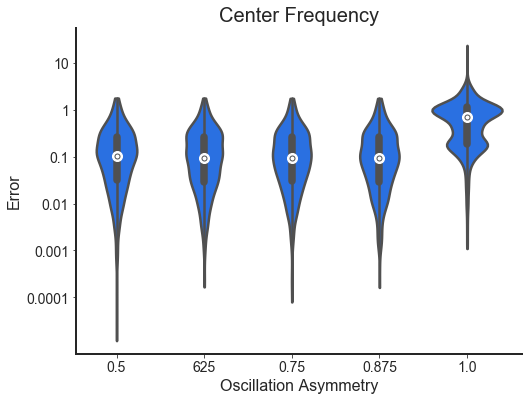

In [27]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(cf_errors, 'Center Frequency', plt_log=PLT_LOG,
                   x_axis='rdsym', ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error'))

##### Number of fit Peaks

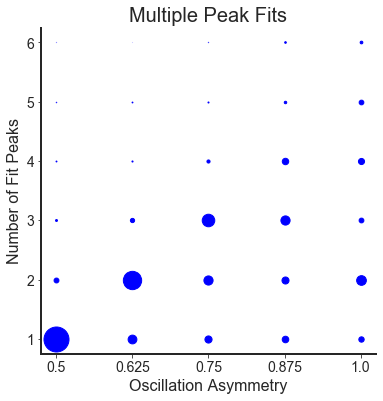

In [28]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, ms_val=15, x_label='rdsym',
                     save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'n_peaks_fit'))

##### Harmonic Structure of Peaks

In the above, we can see that we are fitting more peaks than we might expect, given that there is one actual oscillation in each signal. This is because these asymmetric oscillations create harmonics in the power spectra, which as also fit as peaks. 

To explore this, we can check the 'harmonic structure' of the detected peaks. Harmonics should have a precise relationship between the detected frequencies. 

In the next analysis, we can extract all peaks, and label the lowest detected peak as `f0`. Then we can examine if the other detected peaks have a harmonic relationship to this re-labeled peak. 

The plots below are labeled with `f1` reflecting `2 x f0`, and `f2` reflecting `3 x f0`, etc. In this way, we can see if detected peaks cluster around `f1` and `f2`. If so, this is evidence of harmonic structure in the data. Note that the `f0` peaks themselves are not plotted. 

In [29]:
# Get the harmonic mapping of all the peak center frequencies
harmonic_peaks = [harmonic_mapping(fg) for fg in fgs]

In [30]:
# Collapse across all oscillation strengths
all_harm_peaks = [it for lst in harmonic_peaks for it in lst]

In [31]:
# Grab the harmonic mapping of peaks, separately for cases with 2 and 3 detected peaks
h2s = np.array([val[1] for val in all_harm_peaks if len(val) == 2])
h3s = np.array([val[1:] for val in all_harm_peaks if len(val) == 3])

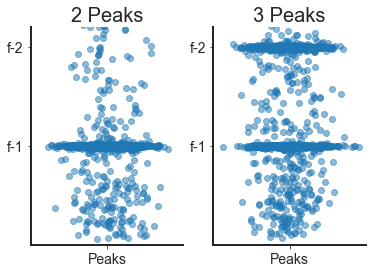

In [32]:
# Plot the harmonic structure of peaks
fig, axes = plt.subplots(1, 2, figsize=[6, 4])
plot_harmonics(h2s, title='2 Peaks', ax=axes[0])
plot_harmonics(h3s, title='3 Peaks', ax=axes[1])

#### Aperiodic Components

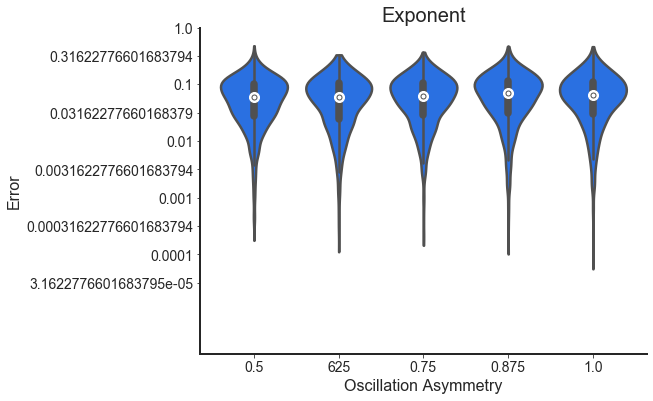

In [37]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent', plt_log=PLT_LOG, 
                   x_axis='rdsym', ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

### Example FOOOF Fits

SimParams(aperiodic_params=[None, -0.5], periodic_params=[21, None, None], nlv=None)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -2.0819, 0.3505                                          
                                                                                                  
                        

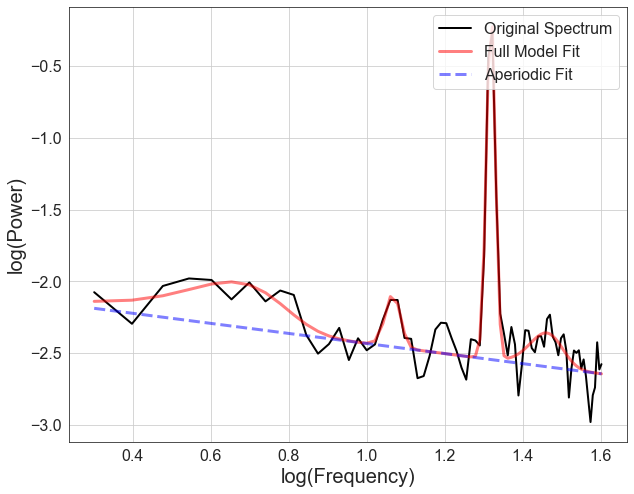

In [34]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name=pjoin(FOLDER, 'example_rdsym1'))

SimParams(aperiodic_params=[None, -1.5], periodic_params=[24, None, None], nlv=None)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.3535, 1.7764                                          
                                                                                                  
                        

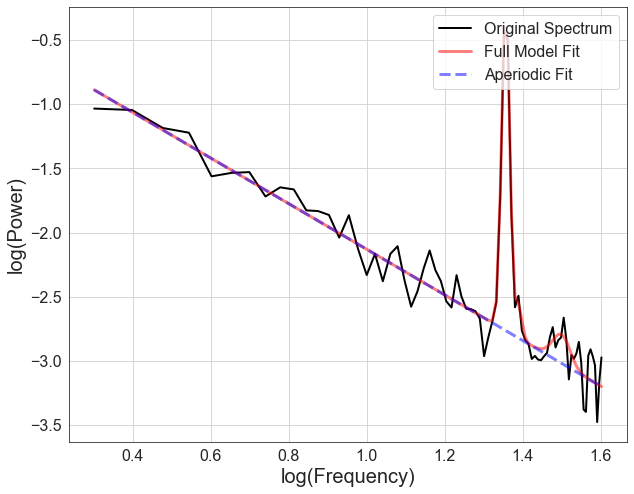

In [35]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm_nlv1.print_results()
fm_nlv1.plot(plt_log=True, save_fig=SAVE_FIG,
             file_path=FIGS_PATH, file_name=pjoin(FOLDER, 'example_rdsym5'))